In [1]:
import pandas as pd
import numpy as np
import os
import re
import seaborn
import matplotlib.pyplot as plt

### Running a small simulation to benchmark several post-model-selection inference procedures

- There has recently been an increasing interest in post-model-selection statistical inference and many approaches have been proposed to ensure inferential validity after selection.
- The interesting and still open research question is, how well different methods perform "in the wild", e.g. with respect to different types of data generating processes, when conducting post-selection statistical inference.

- In this small simulation study I try to contribute by inspecting a few candidate methods, as well as their estimated confidence intervals' coverages, given a partly linear effect across several data generating processes.

The different methods compared are:
- the adaptive lasso (Zou, H. (2006))
- the lasso + naive OLS confidence intervals on remaining covariates afterwards 
- the boruta algorithm (random forests as base learners) + naive OLS confidence intervals on remaining covariates afterwards
- an univariate feature selection approach (scikit learn) + naive OLS confidence intervals on remaining covariates afterwards

Apart from the adaptive lasso (which guarantees selection consistency as well as valid confidence intervals in large samples), all approaches considered here follow a sample-splitting procedure. This is due to the following issue with standard methods:

- If the same data that was  used for selection is also used to provide inference for the selected parameters, standard inferential procedures are unreliable,  typically leading to overoptimistic results; see e.g. Hong et al. (2018).
- Data splitting techniques, where a portion of the data is reserved for uncertainty quantification, offer a simple yet effective way to circumvent this problem (independency)

- While lasso + OLS inference can be seen as a simple, yet valid strategy to go for (if done on different folds of the sample), univariate feature selection works by selecting the best features based on univariate statistical tests, and can be considered as a baseline of how some researchers did model selection by hand in the past- before it became clear that this would lead to non-trustworthy results. However, for consistency among the methods, I also follow the data splitting approach with this univariate selector (making it at least theoretically more reliable, from a perspective focusing on the validity of inference). 
- On the other hand, the boruta algorithm has recently enjoyed a huge popularity in the machine-learning community, for its apparently good practical performance and minimal number of tuning parameters. Equipped with random forests as its base learner, it should even handle non-linearities in the data well.

- Unfortunately and to the best of my knowledge there currently exists no (stable and commonly available) python version of the adaptive lasso yet (which on top of the "standard" lasso would require the option to provide penalty factors for the various covariates within the lasso loss function, which are not provided in scikit learn for example).
- For that reason, I implemented a basic estimator myself, following the coordinate descent method that is also used in the scikit-learn module in python or the glmnet package in R.
- For a short performance overview and build-process of my implementation, see the jupyter notebook "adaptive_lasso_implementation" in the same directory.

- For this simulation study, I consider the following artificial data generating processes:

\begin{equation*}
y_i = \alpha x^1_i + g(u_i) + \epsilon_i, \quad i= 1,2,..,n
\label{eq:vector_ray} \tag{1}
\end{equation*}

where $y_i$ is the one-dim. response, $\alpha x^1_i$ is the true linear effect of interest (confidence intervals shall be constructed for $\alpha$),
$g$ is a potentially non-linear link function, whose input $u_i$ is defined as 
$u_i = \tilde{X}_i \beta_i $, where $\tilde{X}_i$ is the predictor matrix excluding the first predictor, namely $x^1_i$.

- I then inspect the following link functions:

1. "linear_link": $g(u_i) = id(u_i)$
2. "polynomial_link": $g(u_i) = u_i^2 + u_i + 1 $
3. "sine_link": $g(u_i) = sin( 2 u_i) + sin(u_i) + 1$

- The full data matrix $X$ is generated in a way that each row $x_i ∼ \mathcal{N}(0,\Sigma)$.   Here $\Sigma$ is either an identity matrix or has power-decay entries $\Sigma_{ij} = \rho^{|i-j|}, 0 < \rho < 1$. Both of these choices satisfy the strong irrepresentability condition, see e.g. Zou, H. (2006).
- The added noise is not particularly strong, with $\epsilon_i ∼ \mathcal{N}(0,0.5^2)$

- Furthermore, a more realistic data generating process, which is motivated by the real LISS data (for which I wish to conduct inference later), is projected in the following way:
    1. Get a random sample of the data, e.g. of size $\lfloor \frac{n}{2} \rfloor$ (n is sample size).
    2. Make a linear projection of $y$ on the regressor matrix $X$, linearizing the model.
    3. Set medium-to-small regression parameters to zero, inducing some noise and adding sparsity characteristic.
    4. Get estimates from the projected model, using the updated parameters from (3) and adding some additional noise $\eta_i ∼ \mathcal{N}(0,\sigma^2)$.
    
- Following this procedure, we can get a linear characterization of the true conditional expectation function in order to assess coverage of estimated confidence intervals in a controlled environment, where we "know" the data generating process, but do not risk to overfit to the data too much later on.
- This is particularly useful to gain information upon the adequacy of various methods in our real data sample, which includes many binary covariates, as well as a regressor matrix with a non-trivial covariance structure.

### Artificial DGPs

- A last note before looking at the results. In order to measure performance, we need to specify metrics. For the first stage, i.e. model selection,  I considered the following statistics:

1. **share_of_truth_uncovered**: Correctly selected relevant variables relative to total number of relevant variables \n
2. **ratio_total_select_coeffs_true_coeffs**: Number of selected variables relative to total number of relevant variables \n
3. **false_pos_share_true_support**: Number of mistakenly selected variables (which are irrelevant) relative to total number of relevant variables
4. **false_pos_share_right_selection**: Number of mistakenly selected variables (i.e. irrelevant ones) relative to correctly selected (i.e. relevant) variables


- For the second step, i.e. confidence intervals for the linear parts of the DGPs, I simply measure the nominal coverage of the estimated invervals containing the truth, and the respective interval length.


In [2]:
res_artificial_data = pd.read_csv("simulation_study_artificial_results.csv", index_col=["simulation_id", "n_obs", "identity_cov_matrix", "p_features", "link_function", "selector"])
# if you build the whole project, you can also use the line below:
# res_artificial_data = pd.read_csv(os.path.abspath("../..") + "/bld/analysis/simulation_study_artificial_results.csv", index_col=["simulation_id", "n_obs", "identity_cov_matrix", "p_features", "link_function", "selector"])

In [3]:
res_real_data_add_profession_yes_add_political_yes = pd.read_csv("simulation_study_real_dgp_add_profession_yes_add_political_yes.csv", index_col=["simulation_id", "selector"])
# if you build the whole project, you can also use the line below:
# res_real_data_add_profession_yes_add_political_yes = pd.read_csv(os.path.abspath("../..") + "/bld/analysis/simulation_study_real_dgp_add_profession_yes_add_political_yes.csv", index_col=["simulation_id", "selector"])

In [4]:
res_artificial_data['linear_effect_coverage_1_0'] = np.nan 
res_artificial_data['conf_int_lower'] = np.nan 
res_artificial_data['conf_int_upper'] = np.nan 

for i in range(res_artificial_data.shape[0]):
    if not res_artificial_data["conf_int_width"].iloc[i] is np.nan:
        line = res_artificial_data["conf_int_width"].iloc[i]
        line = re.sub(r"[\[\]]", "", line).rstrip()
        res_artificial_data["conf_int_width"].iloc[i] = np.fromstring(line, sep=" ")
        if res_artificial_data["linear_effect_coverage"].iloc[i]:
            res_artificial_data['linear_effect_coverage_1_0'].iloc[i] = 1.0
        if not res_artificial_data["linear_effect_coverage"].iloc[i]:
            res_artificial_data['linear_effect_coverage_1_0'].iloc[i] = 0.0
        res_artificial_data["conf_int_lower"].iloc[i] = res_artificial_data["conf_int_width"].iloc[i][0]
        res_artificial_data["conf_int_upper"].iloc[i] = res_artificial_data["conf_int_width"].iloc[i][1]

/home/helios/miniconda3/envs/cov_vacc_models/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
for i in [0, 1 ,2, 3]:
    level_to_change = i
    res_artificial_data.index = res_artificial_data.index.set_levels(res_artificial_data.index.levels[level_to_change].astype(str), level=level_to_change)

In [6]:
grouped_data = res_artificial_data.groupby(['identity_cov_matrix', 'n_obs', 'p_features', 'link_function', 'selector']).mean()
grouped_data["interval_length"] = grouped_data["conf_int_upper"] - grouped_data["conf_int_lower"]

In [7]:
grouped_data

share_of_truth_uncovered  \
identity_cov_matrix n_obs p_features link_function   selector                                                 
False               100   20         linear_link     adaptive_lasso_tuned                             0.734   
                                                     boruta_selector                                  0.450   
                                                     lasso_feature_selection                          0.904   
                                                     univariate_feature_selection                     0.866   
                                     polynomial_link adaptive_lasso_tuned                             0.182   
...                                                                                                     ...   
True                2000  80         polynomial_link univariate_feature_selection                     0.302   
                                     sine_link       adaptive_lasso_tuned                             0.108   
                                                     boruta_selector                                  0.130   
                                                     lasso_feature_selection                          0.148   
                                                     univariate_feature_selection                     0.102   

                                                                                   ratio_total_select_coeffs_true_coeffs  \
identity_cov_matrix n_obs p_features link_function   selector                                                              
False               100   20         linear_link     adaptive_lasso_tuned                                          0.780   
                                                     boruta_selector                                               0.476   
                                                     lasso_feature_selection                                       1.490   
                                                     univariate_feature_selection                                  1.534   
                                     polynomial_link adaptive_lasso_tuned                                          0.284   
...                                                                                                                  ...   
True                2000  80         polynomial_link univariate_feature_selection                                  0.388   
                                     sine_link       adaptive_lasso_tuned                                          0.126   
                                                     boruta_selector                                               0.278   
                                                     lasso_feature_selection                                       0.372   
                                                     univariate_feature_selection                                  0.124   

                                                                                   false_pos_share_true_support  \
identity_cov_matrix n_obs p_features link_function   selector                                                     
False               100   20         linear_link     adaptive_lasso_tuned                                 0.046   
                                                     boruta_selector                                      0.026   
                                                     lasso_feature_selection                              0.586   
                                                     univariate_feature_selection                         0.668   
                                     polynomial_link adaptive_lasso_tuned                                 0.102   
...                                                                                                         ...   
True                2000  80         polynomial_link univariate_feature_selection                         

Text(0.5, 0.98, 'Percentage of true covariates selected: n=2000 and p = 20')

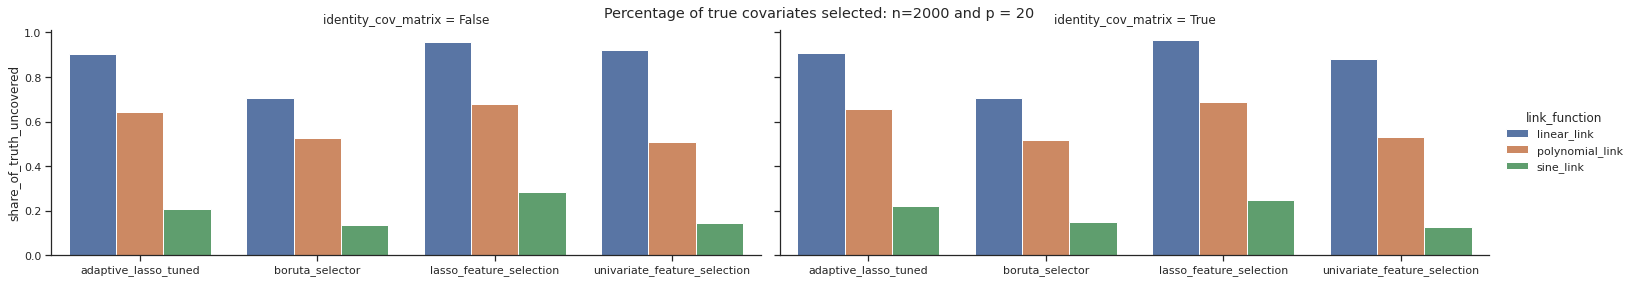

In [104]:
seaborn.set(style='ticks') 

fg = seaborn.catplot(x='selector', y='share_of_truth_uncovered', hue='link_function', 
                        col='identity_cov_matrix', data=grouped_data.xs(('2000', '20'), level=(1,2)).reset_index(), kind='bar', height=4, aspect=2.6)
fg.set_xlabels('')
fg.fig.suptitle('Percentage of true covariates selected: n=2000 and p = 20')

Text(0.5, 0.98, 'Percentage of true covariates selected: n=100 and p = 80')

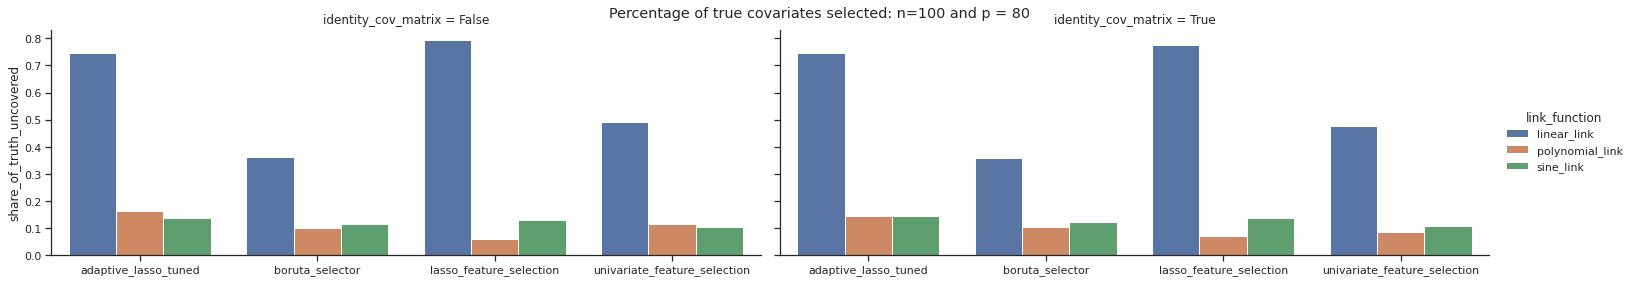

In [105]:
seaborn.set(style='ticks') 

fg = seaborn.catplot(x='selector', y='share_of_truth_uncovered', hue='link_function', 
                        col='identity_cov_matrix', data=grouped_data.xs(('100', '80'), level=(1,2)).reset_index(), kind='bar', height=4, aspect=2.6)
fg.set_xlabels('')
fg.fig.suptitle('Percentage of true covariates selected: n=100 and p = 80')

Text(0.5, 0.98, 'Ratio: Number selected covariates / true number of relevant covariates for n=2000 and p = 20')

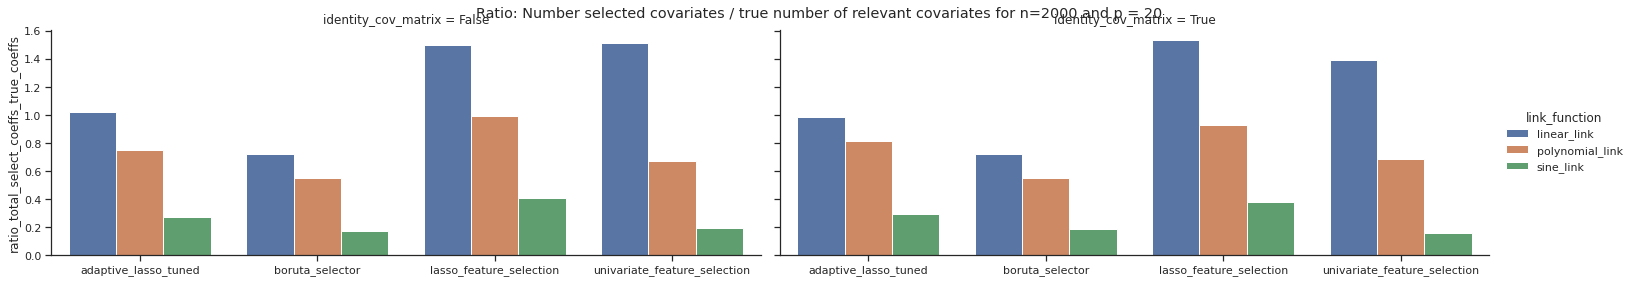

In [106]:
seaborn.set(style='ticks') 

fg = seaborn.catplot(x='selector', y='ratio_total_select_coeffs_true_coeffs', hue='link_function', 
                        col='identity_cov_matrix', data=grouped_data.xs(('2000', '20'), level=(1,2)).reset_index(), kind='bar', height=4, aspect=2.6)
fg.set_xlabels('')
fg.fig.suptitle('Ratio: Number selected covariates / true number of relevant covariates for n=2000 and p = 20')

Text(0.5, 0.98, 'Ratio: Number selected covariates / true number of relevant covariates for n=100 and p = 80')

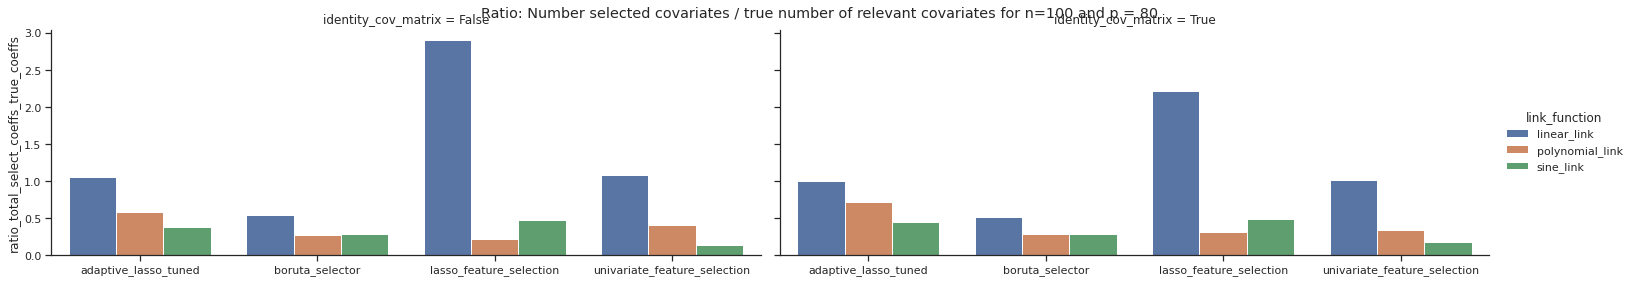

In [107]:
seaborn.set(style='ticks') 

fg = seaborn.catplot(x='selector', y='ratio_total_select_coeffs_true_coeffs', hue='link_function', 
                        col='identity_cov_matrix', data=grouped_data.xs(('100', '80'), level=(1,2)).reset_index(), kind='bar', height=4, aspect=2.6)
fg.set_xlabels('')
fg.fig.suptitle('Ratio: Number selected covariates / true number of relevant covariates for n=100 and p = 80')

Text(0.5, 0.98, 'Nominal coverage for linear parameter for n=2000 and p = 20')

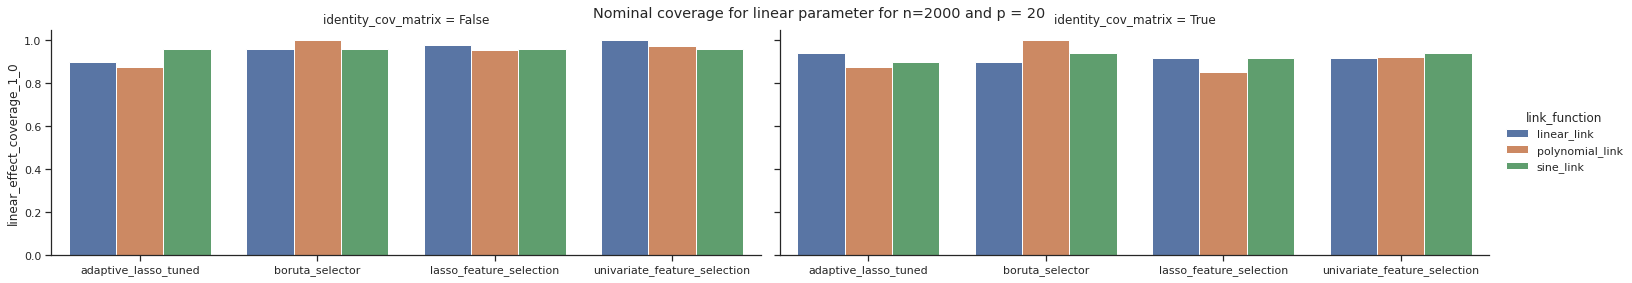

In [112]:
seaborn.set(style='ticks') 

fg = seaborn.catplot(x='selector', y='linear_effect_coverage_1_0', hue='link_function', 
                        col='identity_cov_matrix', data=grouped_data.xs(('2000', '20'), level=(1,2)).reset_index(), kind='bar', height=4, aspect=2.6)
fg.set_xlabels('')
fg.fig.suptitle('Nominal coverage for linear parameter for n=2000 and p = 20')

Text(0.5, 0.98, 'Nominal coverage for linear parameter for n=100 and p = 80')

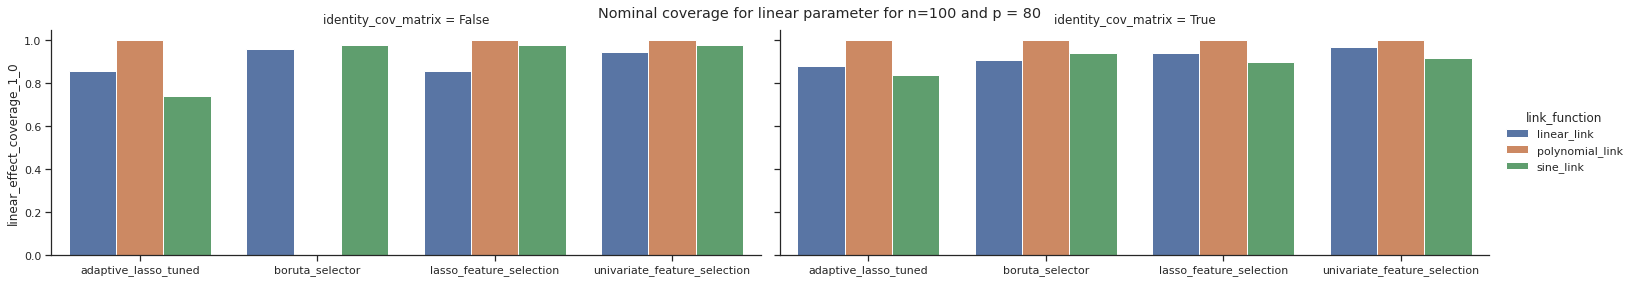

In [113]:
seaborn.set(style='ticks') 

fg = seaborn.catplot(x='selector', y='linear_effect_coverage_1_0', hue='link_function', 
                        col='identity_cov_matrix', data=grouped_data.xs(('100', '80'), level=(1,2)).reset_index(), kind='bar', height=4, aspect=2.6)
fg.set_xlabels('')
fg.fig.suptitle('Nominal coverage for linear parameter for n=100 and p = 80')

Text(0.5, 0.98, 'Conf. inter. length for linear parameter for n=2000 and p = 20')

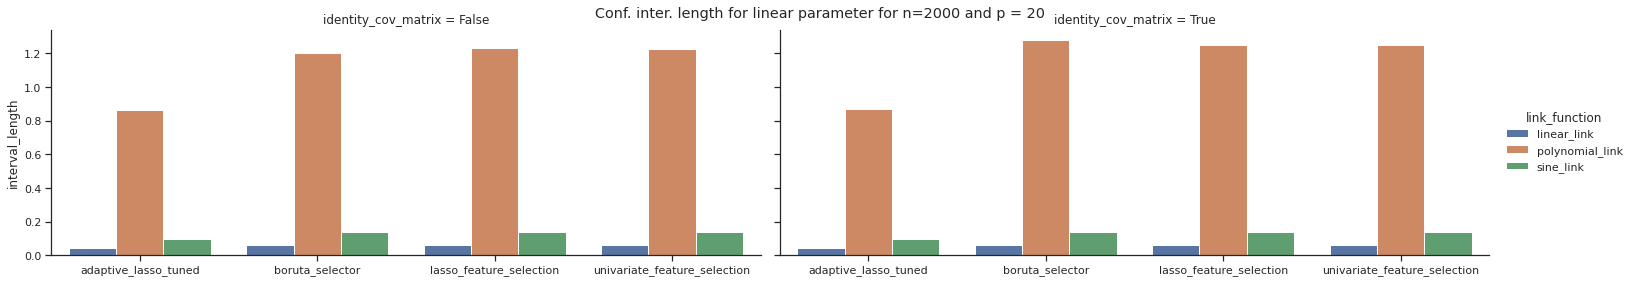

In [114]:
seaborn.set(style='ticks') 

fg = seaborn.catplot(x='selector', y='interval_length', hue='link_function', 
                        col='identity_cov_matrix', data=grouped_data.xs(('2000', '20'), level=(1,2)).reset_index(), kind='bar', height=4, aspect=2.6)
fg.set_xlabels('')
fg.fig.suptitle('Conf. inter. length for linear parameter for n=2000 and p = 20')

Text(0.5, 0.98, 'Conf. inter. length for linear parameter for n=100 and p = 80')

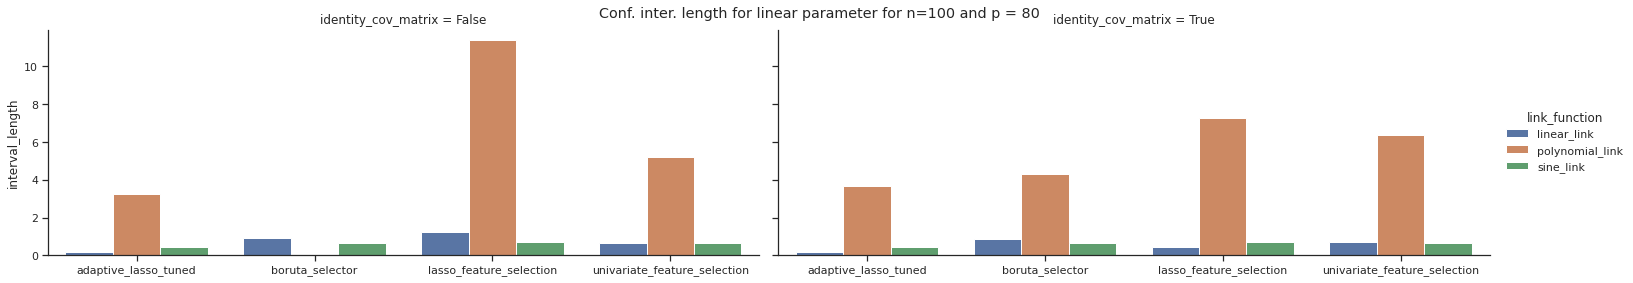

In [115]:
seaborn.set(style='ticks') 

fg = seaborn.catplot(x='selector', y='interval_length', hue='link_function', 
                        col='identity_cov_matrix', data=grouped_data.xs(('100', '80'), level=(1,2)).reset_index(), kind='bar', height=4, aspect=2.6)
fg.set_xlabels('')
fg.fig.suptitle('Conf. inter. length for linear parameter for n=100 and p = 80')

### DGP motivated by real-world LISS data

- For the first stage (i.e. model selection), the same metrics as before are evaluated.
- For the second step, however, by construction of the DGP and its linearity, we can get coverage measures for all coefficients that were chosen. There are various strategies to proceed, since in model selection (true) null effects could be included, such that confidence intervals are not limited to the relevant covariates only.
- However, the calculation of confidence intervals for the adaptive lasso and other methods is limited only to variables that were ex ante chosen relevant, i.e. we cannot compare confidence intervals for all possible covariates and the comparison across different methods that chose different sets of relevant covariates is more difficult.
- Therefore, I constructed the following metric: 

For each of the four selection strategies:

1. Take all covariates that were considered relevant in the first stage and calculate confidence intervals for those, even though some might not be truly relevant.
2. Check for each true coefficient corresponding to those chosen covariates, whether it lies within its respective constructed confidence interval; count the number where this is true.
3. Then scale (i.e. divide) by the total number of the selected covariates from the first stage.

- This measure focuses more on the correctness of confidence intervals (even for non-relevant regressors), because we already have measures for the selection consistency.
- Furthermore, the scaling at the end guarantees that we have a comparable metric across the different approaches.


In [8]:
res_real_data_add_profession_yes_add_political_yes

share_of_truth_uncovered  \
simulation_id selector                                                 
0             boruta_selector                               0.142857   
              univariate_feature_selection                  0.987013   
              lasso_feature_selection                       0.025974   
              adaptive_lasso_tuned                          0.922078   
1             boruta_selector                               0.105263   
...                                                              ...   
248           adaptive_lasso_tuned                          0.972973   
249           boruta_selector                               0.160000   
              univariate_feature_selection                  0.986667   
              lasso_feature_selection                       0.026667   
              adaptive_lasso_tuned                          0.986667   

                                            ratio_total_select_coeffs_true_coeffs  \
simulation_id selector                                                              
0             boruta_selector                                            0.142857   
              univariate_feature_selection                               1.129870   
              lasso_feature_selection                                    0.038961   
              adaptive_lasso_tuned                                       0.922078   
1             boruta_selector                                            0.105263   
...                                                                           ...   
248           adaptive_lasso_tuned                                       1.000000   
249           boruta_selector                                            0.186667   
              univariate_feature_selection                               1.160000   
              lasso_feature_selection                                    0.053333   
              adaptive_lasso_tuned                                       0.986667   

                                            false_pos_share_true_support  \
simulation_id selector                                                     
0             boruta_selector                                   0.000000   
              univariate_feature_selection                      0.142857   
              lasso_feature_selection                           0.012987   
              adaptive_lasso_tuned                              0.000000   
1             boruta_selector                                   0.000000   
...                                                                  ...   
248           adaptive_lasso_tuned                              0.027027   
249           boruta_selector                                   0.026667   
              univariate_feature_selection                      0.173333   
              lasso_feature_selection                           0.026667   
              adaptive_lasso_tuned                              0.000000   

                                            false_pos_share_right_selection  \
simulation_id selector                                                        
0             boruta_selector                                      0.000000   
              univariate_feature_selection                         0.144737   
              lasso_feature_selection                              0.500000   
              adaptive_lasso_tuned                                 0.000000   
1             boruta_selector                                      0.000000   
...                                                                     ...   
248           adaptive_lasso_tuned                                 0.027778   
249           boruta_selector                                      0.166667   
              univariate_feature_selection                         0.175676   
              lasso_feature_selection                              1.000000   
              adaptive_lasso_tuned                              

In [9]:
grouped_real_data = res_real_data_add_profession_yes_add_political_yes.groupby(['selector']).mean()

In [10]:
grouped_real_data

,share_of_truth_uncovered,ratio_total_select_coeffs_true_coeffs,false_pos_share_true_support,false_pos_share_right_selection,linear_effect_coverage
selector,,,,,
adaptive_lasso_tuned,0.953499,0.955684,0.002186,0.002252,0.842698
boruta_selector,0.119006,0.127266,0.008260,0.073007,0.355542
lasso_feature_selection,0.025717,0.040094,0.014377,0.600000,0.015667
univariate_feature_selection,0.979309,1.137748,0.158438,0.161499,0.864589


It is visible that the adaptive lasso and the univariate feature selection uncover most of the truly relevant factors. However, in the univariate selection this comes at the cost of selecting too many variables (also non-relevant ones, i.e. many false positives). Adpative Lasso, on the contrary, seems to nearly have no false positive selections and has a ratio between its selected covariates to the true relevant covariates smaller than one. What is striking and mysterious is the very poor performance of the "normal" cross-validated lasso, uncovering < 5% of the true relevant regressors. Boruta, which has already been conservative in the simulations before, seems to continue having nearly no false positives in selection, but also only uncovering roughly 10% of the truth.
The coverage of the confidence intervals is really weak for lasso, as well as for boruta. For the adaptive lasso the percentage of 85% is coming closer to the 95% nominal coverage, however still underperforming a bit. The univariate method is doing best here within a small margin.